In [ ]:
'''
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''

'\n!sudo apt-get install -y fonts-nanum\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf\n'

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
mpl.rcParams['axes.unicode_minus'] = False

# 4.5 규제가 있는 선형 모델

과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것이다. 선형 회귀모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가한다. 각기 다른 방법으로 가중치를 제한하는 '릿지'회귀, '라쏘'회귀, 엘라스틱넷을 살펴보자

## 4.5.1 릿지 회귀

- 릿지 회귀는 규제가 추가된 선형 회귀 버전으로, 규제항이 비용함수에 추가된다. 이는 모델의 가중치가 가능한 작게 유지되도록 노력한다.
- 규제항은 훈련하는 동안에만 비용함수에 추가되고 모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 사용한다.

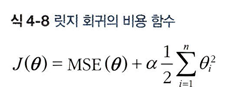

- 하이퍼파라미터 a는 모델을 얼마나 많이 규제할지 조절한다. a=0이면 선형회귀와 같아지고 a가 아주 크면 모든 가중치가 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 된다.

In [ ]:
# 정규방정식을 사용한 릿지 회귀를 적용하는 예

from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([4.82497007])

In [ ]:
# 확률적 경사 하강법을 사용했을 때

sgd_reg = SGDRegressor(penalty = "l2", random_state = 42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.81978491])

## 4.5.2 라쏘 회귀

- 라쏘 회귀는 선형 회귀의 또 다른 규제 버전이다.

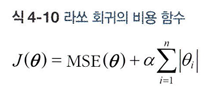

In [ ]:
# Lasso 클래스를 사용한 간단한 사이킷런 예제

from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.1)

lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

## 4.5.3 엘라스틱넷

- 엘라스틱은 릿지와 라쏘 회귀를 절충한 모델이다. r=0이면 릿지회귀와 같고 r=1이면 라쏘 회귀와 같다.

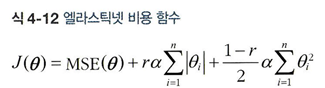

- 적어도 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피해야 함
- 릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심되면 **라쏘나 엘라스틱넷**이 낫다. 이 모델들은 **불필요한 특성의 가중치를 0으로** 만들어준다.
- **특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어있는 경우** 라쏘보다는 엘라스틱넷을 선호한다.

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5, random_state = 42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

## 4.5.4 조기 종료

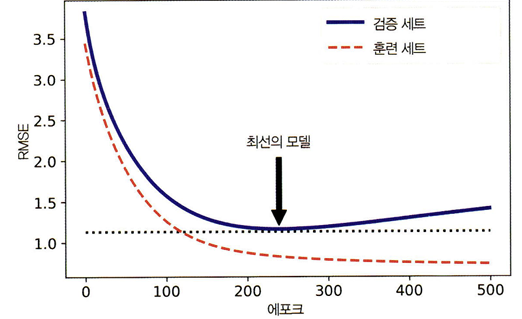

에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측에러와 검증 세트에 대한 예측에러가 줄어든다. 그러나 잠시 후 감소하던 검증 에러가 멈추었다가 다시 상승한다. 이는 모델이 훈련 데이터에 과대적합되기 시작하는 것을 의미한다. **조기 종료는 검증 에러가 최소에 도달하는 즉시 훈련을 멈추는** 것이다.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X ** 2 + np.random.randn(m, 1)
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size = 0.5, random_state = 10)


In [ ]:
# 조기종료를 위한 기본 구현 코드

from sklearn.base import clone

# 데이터 준비
poly_scaler = Pipeline([
                        ("poly_features", PolynomialFeatures(degree = 90, include_bias = False)),
                        ("std_scaler", StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# warm_start = True 시 fit() 메서드가 호출될 때 이전 모델 파라미터에서 훈련을 이어갑니다.
sgd_reg = SGDRegressor(max_iter = 1, tol = None, warm_start = True, penalty = None, learning_rate = "constant", eta0 = 0.0005, random_state = 42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000) :
  sgd_reg.fit(X_train_poly_scaled, y_train) # 훈련을 이어서 진행 합니다.

  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)

  if val_error < minimum_val_error :
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

# 4.6 로지스틱 회귀

- 로지스틱 회귀는 분류에서도 사용할 수 있다. 추정 확률이 0.5를 넘으면 그 샘플이 해당 클래스에 속한다고 예측하고 아니면 클래스에 속하지 않는다고 예측한다.

## 4.6.1 확률 추정

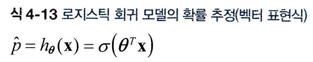

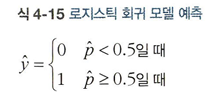

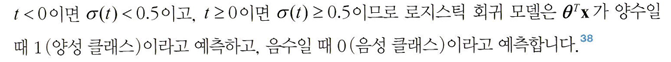

## 4.6.3 결정 경계

- 로지스틱 회귀를 설명하기 위해 붓꽃 데이터셋 사용
- 세 개의 품종 Setosa(0), Versicolor(1), Virginica(2)에 속하는 붓꽃 150개의 꽃잎(petal)과 꽃받침(sepal)의 너비와 길이를 담고 있다.

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

# Iris 데이터 로드
iris = load_iris()

# 데이터프레임으로 변환
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# 처음 3개 행 출력
print(df.head(3))

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2


In [ ]:
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
X = iris["data"][:, 3:] # 꽃잎 너비
y = (iris["target"] == 2).astype(int) # iris virginica이면 1 아니면 0

In [ ]:
# 로지스틱 모델 훈련

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver = "lbfgs", random_state = 42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

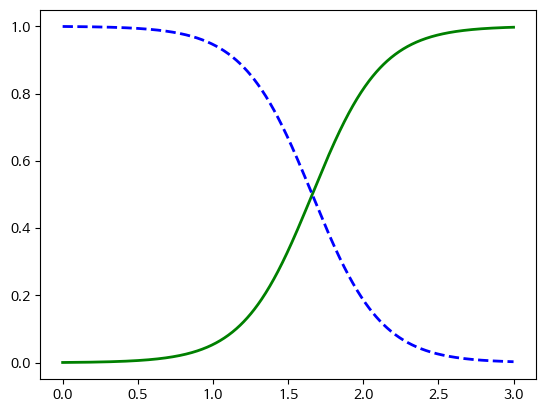

In [ ]:
# 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정확률을 계산
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-",  linewidth = 2, label = "Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth = 2, label = "Iris virginica 아님")

=> 양쪽 확률이 똑같이 50%가 되는 1.6cm 근방에서 결정 경계가 만들어진다. 아래 코드로 확인할 수 있다.

In [ ]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## 4.6.4 소프트맥스 회귀 (다항 로지스틱 회귀)

- 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 sk(x)를 계산하고, 그 점수에 소프트맥수 함수를 적용하여 각 클래스의 확률을 추정한다.

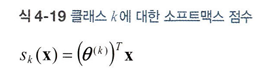

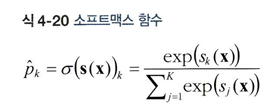

- 로지스틱 회귀분류기와 마찬가지로 소프트맥스 회귀 분류기는 추정확률이 가장 높은 클래스를 선택

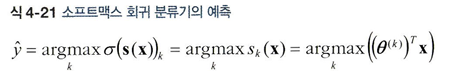

In [ ]:
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", C = 10, random_state = 42)
softmax_reg.fit(X, y)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [ ]:
softmax_reg.predict([[5, 2]])

array([2])

In [ ]:
softmax_reg.predict_proba([[5, 2]])

array([[6.21626375e-07, 5.73689803e-02, 9.42630398e-01]])

=> 94.2%의 확률로 Virginica (클래스 2)라고 출력할 것이다.